In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import natasha

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None 

In [48]:
train = pd.read_csv('C:/Users/user/damn-dataset/train.csv', sep=";")
test = pd.read_csv('C:/Users/user/damn-dataset/test dataset.csv', sep=";")
test.drop(columns=['id'], inplace=True)

external_web_prices = pd.read_csv('C:/Users/user/damn-dataset/external/web_prices.csv', decimal=',')
external_demography = pd.read_csv('C:/Users/user/damn-dataset/external/population.csv')

In [50]:
web_data = {
    'city_name': external_web_prices['Unnamed: 0'][1::2].values, 
    'average_price': external_web_prices['Unnamed: 8'][::2][1:].values
}

external_data = pd.DataFrame(data=web_data)

In [51]:
from geopy.geocoders import Nominatim
from geopy.point import Point
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="test")

def place_geocoding(place):
    try:
        location = geolocator.geocode(place)
        lat, lon = int(location.latitude), int(location.longitude)
        place = str([lat, lon])

        return place
        
    except:
        return 'Деревня'

def reverse_geocoding(lat, lon):
    try:
        location = geolocator.reverse(Point(lat, lon))
        return location.raw['address']['city']

    except:
        return 'Деревня'

def geodistances(lat, lon):
    standart = (0.99, 1.85)
    
    dist = geodesic(standart, (lat, lon), ellipsoid='WGS-84').km

    return dist

In [7]:
external_data['place_coordinates'] = np.vectorize(place_geocoding)(
    external_data['city_name']
)

In [52]:
import numpy as np

train.loc[train['city_name'].isnull() == True, 'city_name'] = np.vectorize(reverse_geocoding)(
    train[(train['city_name'].isnull() == True)]['hex_lat'], 
    train[(train['city_name'].isnull() == True)]['hex_lon']
)

test.loc[test['city_name'].isnull() == True, 'city_name'] = np.vectorize(reverse_geocoding)(
    test[(test['city_name'].isnull() == True)]['hex_lat'], 
    test[(test['city_name'].isnull() == True)]['hex_lon']
)

In [63]:
train = pd.merge(train, external_data, on='city_name', how='left')
test = pd.merge(test, external_data, on='city_name', how='left')

train['average_price'] = train['average_price'].str.replace(',', '.').astype(float)
test['average_price'] = test['average_price'].str.replace(',', '.').astype(float)

In [ ]:
service_train = train[train['average_price'].isnull() == True]
service_train['place_coordinates'] = "[" + service_train['hex_lat'].astype(str) + ", " + service_train['hex_lon'].astype(str) + "]"
to_attach = pd.merge(service_train, external_data, on='place_coordinates', how='outer')

#train.loc[train['average_price'].isnull() == True, 'average_price'] = to_attach['average_price']

#--------------------------------------------------------------------------------
service_test = test[test['average_price'].isnull() == True]
service_test['place_coordinates'] = "[" + service_test['hex_lat'].astype(str) + ", " + service_test['hex_lon'].astype(str) + "]"
to_attach = pd.merge(service_test, external_data, on='place_coordinates', how='outer')

In [ ]:
train['label'].value_counts()

0    283986
1      7106
Name: label, dtype: int64

In [55]:
train['period'] = train['period'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
train = train.sort_values('period')

test['period'] = test['period'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))
test = test.sort_values('period')

In [57]:
for column in train.columns:
    if train[column].isnull().sum() > 100000:
        train.drop(columns=[column], inplace=True)
        test.drop(columns=[column], inplace=True)

In [58]:
train['hex'] = train['hex'].apply(int, base=16)
test['hex'] = test['hex'].apply(int, base=16)

In [60]:
train['dist'] = np.vectorize(geodistances)(
    train['hex_lat'], 
    train['hex_lon']
)

test['dist'] = np.vectorize(geodistances)(
    test['hex_lat'], 
    test['hex_lon']
)

In [ ]:
train = pd.merge(train, external_data, on='city_name', how='left')
test = pd.merge(test, external_data, on='city_name', how='left')

train['average_price'] = train['average_price'].str.replace(',', '.').astype(float)
test['average_price'] = test['average_price'].str.replace(',', '.').astype(float)

In [64]:
train = train.fillna(train.median())

test = test.fillna(test.median())

C:\Users\user\AppData\Local\Temp\ipykernel_13680\2372157984.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train = train.fillna(train.median())
C:\Users\user\AppData\Local\Temp\ipykernel_13680\2372157984.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test = test.fillna(test.median())


In [62]:
test

,label,period,subject_type,subject_name,city_name,hex,hex_lat,hex_lon,f1,f2,f3,f4,f5,f6,f8,f9,f10,f11,f12,f14,f15,f18,f19,f20,f21,f22,f23,f29,f30,dist
0,0,2020-11-01,Город,Москва,Москва,603793125982339071,55.855726,37.669858,0.00115,0.00082,0.00099,0.00000,0.0000,0.01028,0.00000,0.00000,0.12721,0.31457,0.14915,0.0,0.00503,0.00898,0.29623,0.02424,0.14273,0.00000,0.00000,0.00449,0.00000,6882.073139
10167,0,2020-11-01,Город,Москва,Москва,603793132559007743,55.763492,37.596292,0.00043,0.00059,0.00074,0.00000,0.0000,0.01851,0.00000,0.00000,0.12650,0.31457,0.14813,0.0,0.00022,0.00718,0.20646,0.02693,0.15440,0.00000,0.00000,0.00359,0.00000,6871.331142
10168,0,2020-11-01,Город,Москва,Москва,603793120210976767,55.613025,37.529612,0.00030,0.00025,0.00032,0.00000,0.0000,0.41867,0.00000,0.00000,0.12699,0.31457,0.14912,0.0,0.00034,0.00267,0.29907,0.02804,0.12550,0.00000,0.00000,0.00267,0.00000,6856.014202
10169,0,2020-11-01,Город,Москва,Москва,603793120479412223,55.554789,37.536107,0.00083,0.00044,0.00073,0.00000,0.0000,0.01306,0.00000,0.00000,0.12626,0.31747,0.14790,0.0,0.00048,0.02912,0.45477,0.02107,0.25651,0.00000,0.00062,0.00682,0.00124,6851.435205
10170,0,2020-11-01,Город,Москва,Марушкино,603793116855533567,55.593005,37.199516,0.00172,0.00164,0.00198,0.00000,0.0000,0.02573,0.00000,0.00000,0.12606,0.31961,0.14770,0.0,0.00136,0.01739,0.64530,0.01282,0.17521,0.00000,0.00000,0.01282,0.00000,6840.586774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146077,0,2021-06-01,Республика,Саха /Якутия/,Чукар,603858797777125375,63.730625,118.007646,0.00020,0.00041,0.00065,0.01149,0.0000,0.00347,0.00073,0.00073,0.12783,0.31783,0.14951,0.0,0.00055,0.01124,0.77143,0.01905,0.33333,0.33333,0.00000,0.03809,0.00000,11160.528546
146076,0,2021-06-01,Край,Хабаровский,Князе-Волконское-1,603848932505681919,48.496592,135.477992,0.00075,0.00071,0.00081,0.01724,0.0087,0.04700,0.00073,0.00073,0.12606,0.31948,0.14770,0.0,0.00076,0.08083,0.85254,0.08756,0.41014,0.39631,0.00000,0.06912,0.00230,12948.956284
146075,0,2021-06-01,Край,Хабаровский,Молодежный,603848832916127743,50.385226,136.986193,0.00077,0.00082,0.00102,0.00000,0.0000,0.02298,0.00000,0.00000,0.12823,0.32114,0.14982,0.0,0.00080,0.14912,0.91729,0.08271,0.31579,0.16541,0.00000,0.08271,0.00000,12908.436811
146089,0,2021-06-01,Край,Хабаровский,Хабаровск,603848919620780031,48.372346,135.080498,0.00026,0.00028,0.00033,0.00000,0.0000,0.02000,0.00000,0.00000,0.12783,0.31457,0.14943,0.0,0.00192,0.07558,0.65370,0.05448,0.21206,0.26459,0.00000,0.02724,0.00000,12933.312811


Text(0.5, 1.0, 'Correlation Heatmap for Train dataset')

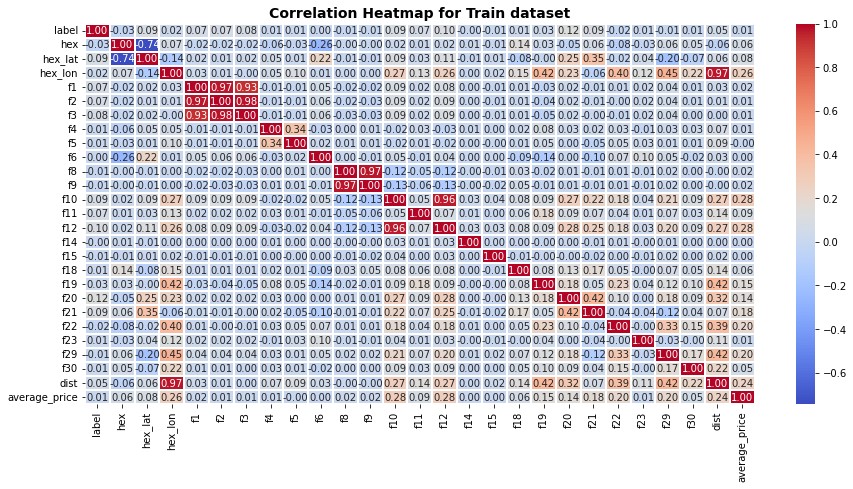

In [23]:
from matplotlib import colors, pyplot as plt
%matplotlib inline

features  = [col for col in train.columns if col not in ("sequence","step","subject")]
plt.figure(figsize = (15,7))

hm = sns.heatmap(train[features].corr(),    # data
                cmap = 'coolwarm',# style
                annot = True,     # True to show the specific values
                fmt = '.2f',      # set the precision
                linewidths = 0.05)
plt.title('Correlation Heatmap for Train dataset', 
              fontsize=14, 
              fontweight='bold')

In [66]:
train.drop(columns=['hex', 'hex_lat', 'hex_lon', 'period', 'subject_name', 'subject_type', 'city_name'], inplace=True)
test.drop(columns=['hex', 'hex_lat', 'hex_lon', 'period', 'subject_name', 'subject_type', 'city_name'], inplace=True)

In [70]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# transform data
train[train.drop(columns=['label']).columns] = scaler.fit_transform(train[train.drop(columns=['label']).columns])
test[test.drop(columns=['label']).columns] = scaler.fit_transform(test[test.drop(columns=['label']).columns])

In [108]:
train

,label,f1,f2,f3,f4,f5,f6,f8,f9,f10,f11,f12,f14,f15,f18,f19,f20,f21,f22,f23,f29,f30,dist,average_price
0,1,0.434016,0.444364,1.018595,-0.277367,-0.132010,1.505500,-0.148842,-0.168345,0.000669,5.602685,-0.079217,-0.027884,0.187241,-0.206133,-1.451200,-0.126716,-0.231359,-0.483013,-0.275565,0.839204,-0.110649,-0.561414,-0.234450
1,0,0.034370,-0.042705,0.003115,-0.277367,-0.132010,1.505500,-0.148842,-0.168345,-0.444956,0.496128,-0.495720,-0.027884,-0.203134,-0.232335,0.785591,0.047876,-0.201696,-0.483013,-0.275565,0.161591,-0.110649,-0.576943,-0.234450
2,0,0.145899,0.176953,0.118698,-0.277367,-0.132010,1.505500,-0.148842,-0.168345,-0.113108,0.947465,-0.178816,-0.027884,0.072425,-0.213827,-0.590525,0.810492,-0.383245,-0.483013,-0.275565,0.641368,-0.110649,-0.555528,-0.234450
3,0,-0.430335,-0.424720,-0.442705,-0.277367,-0.132010,1.505500,-0.148842,-0.168345,-0.862136,0.269170,-0.885060,-0.027884,-0.004925,-0.333192,-1.343660,0.183545,-0.356191,-0.483013,0.898216,1.005501,-0.110649,-0.552635,-0.234450
4,0,0.815074,0.635371,1.051618,-0.277367,-0.132010,1.505500,-0.148842,-0.168345,0.436812,-0.803722,0.328231,-0.027884,0.001118,-0.347541,-2.083075,0.100783,-0.452924,-0.483013,-0.275565,0.374719,-0.110649,-0.559512,-0.234450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291087,0,-0.300217,-0.300565,-0.318866,-0.277367,-0.132010,-0.825937,0.062449,0.335990,1.356506,0.815933,1.650175,-0.027884,-0.175336,0.085418,0.794078,1.157410,0.929961,2.075993,-0.275565,1.949762,-0.110649,3.286001,-0.136241
291088,0,0.638487,0.855030,0.845220,-0.277367,-0.132010,-0.598332,0.001106,-0.045969,-0.103626,-0.803722,0.292013,-0.027884,-0.256312,0.537923,2.292092,0.174853,0.709005,1.364775,-0.275565,3.624202,-0.110649,3.227906,-0.136241
291089,0,1.660837,1.227494,0.869988,4.414059,9.625887,-0.852277,-0.148842,-0.168345,1.821093,1.630919,2.084786,-0.027884,-0.118533,0.501947,1.212150,0.469620,1.040699,1.022233,-0.275565,3.363288,-0.110649,3.439086,-0.136241
291090,0,-0.114335,-0.195511,-0.252819,-0.277367,-0.132010,-0.834352,-0.148842,-0.168345,1.109990,2.353058,2.066678,-0.027884,0.513561,0.865241,0.452679,-0.229507,1.398055,1.092684,-0.275565,5.450603,3.330425,2.539915,-0.136241


In [28]:
train.to_csv('C:/Users/user/Desktop/data/train_numeric.csv', index=False)
test.to_csv('C:/Users/user/Desktop/data/test_numeric.csv', index=False)

In [32]:
train.drop(columns=['city_name'], inplace=True)
test.drop(columns=['city_name'], inplace=True)